# Better image tiles - Simple heuristic to suppress blank regions

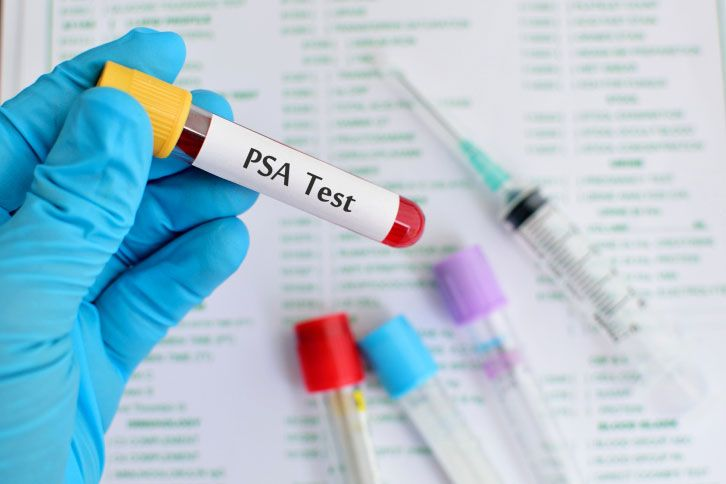

As you might know, for this competition, it is critical to come up with an efficient way to pre-process the images. One of the key aspects that I show in my previous notebook https://www.kaggle.com/rftexas/gradcam-comparing-resnet-and-se-resnext is that as expected white regions don't convey any information, hence the need to get rid of them. 

Actually, one need to zoom enough in the biopsy image to make sure there is **as little white as possible**.

This is why in this notebook, we will code a **simple heuristic** to generate better images that have no more blank parts.

The algorithm is pretty simple actually: having a **sliding window moving across the images** and calculating for each region the proporition of white color in the image. Then **select k regions** with the lowest proportion of white.

We will define the algorithm as follows:
- Define a sliding window of a fixed size
- Slide the window with a certain stride
- For each region on which we slide, compute the amount of white pixels
- Do this for all the regions in the image
- Select the top k results where k is a hyperparameter


** If you like those kinds of tutorials, upvote this notebook! It encourages me to keep writing some ;) **

V5: I'll try to tackle pen markers now! Stay tuned! 

# Contents

- <a href='#1'>1. Importing dependencies</a>
- <a href='#2'>2. Compute statistics</a>
- <a href='#3'>3. Select k-best regions</a>
- <a href='#4'>4. Slide over the image</a>
- <a href='#5'>5. Show the results</a>

    - <a href='#5.1.'>5.1. Window size: 200, stride: 128</a>
    - <a href='#5.2.'>5.2. Window size: 128, stride: 64</a>
    - <a href='#5.3.'>5.3. Window size: 512, stride: 256</a>

## Importing dependencies

In [ ]:
import os
import cv2
import PIL
import random
import openslide
import skimage.io
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [ ]:
train_df = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv').sample(n=10, random_state=0).reset_index(drop=True)

images = list(train_df['image_id'])
labels = list(train_df['isup_grade'])

In [ ]:
data_dir = '../input/prostate-cancer-grade-assessment/train_images/'

## Compute statistics

First we need to write a function to compute the proportion of white pixels in the region.

In [ ]:
def compute_statistics(image):
    """
    Args:
        image                  numpy.array   multi-dimensional array of the form WxHxC
    
    Returns:
        ratio_white_pixels     float         ratio of white pixels over total pixels in the image 
    """
    width, height = image.shape[0], image.shape[1]
    num_pixels = width * height
    
    num_white_pixels = 0
    
    summed_matrix = np.sum(image, axis=-1)
    # Note: A 3-channel white pixel has RGB (255, 255, 255)
    num_white_pixels = np.count_nonzero(summed_matrix > 620)
    ratio_white_pixels = num_white_pixels / num_pixels
    
    green_concentration = np.mean(image[1])
    blue_concentration = np.mean(image[2])
    
    return ratio_white_pixels, green_concentration, blue_concentration

## Select k-best regions

Then we need a function to sort a list of tuples, where one component of the tuple is the proportion of white pixels in the regions. We are sorting in ascending order.

In [ ]:
def select_k_best_regions(regions, k=20):
    """
    Args:
        regions               list           list of 2-component tuples first component the region, 
                                             second component the ratio of white pixels
                                             
        k                     int            number of regions to select
    """
    regions = [x for x in regions if x[3] > 180 and x[4] > 180]
    k_best_regions = sorted(regions, key=lambda tup: tup[2])[:k]
    return k_best_regions

Since we will only store, the coordinates of the top-left pixel, we need a way to retrieve the k best regions, hence the function hereafter...

In [ ]:
def get_k_best_regions(coordinates, image, window_size=512):
    regions = {}
    for i, tup in enumerate(coordinates):
        x, y = tup[0], tup[1]
        regions[i] = image[x : x+window_size, y : y+window_size, :]
    
    return regions

## Slide over the image

The main function: the two while loops slide over the image (the first one from top to bottom, the second from left to right). The order does not matter actually.
Then you select the region, compute the statistics of that region, sort the array and select the k-best regions.

In [ ]:
def generate_patches(slide_path, window_size=200, stride=128, k=20):
    
    image = skimage.io.MultiImage(slide_path)[-2]
    image = np.array(image)
    
    max_width, max_height = image.shape[0], image.shape[1]
    regions_container = []
    i = 0
    
    while window_size + stride*i <= max_height:
        j = 0
        
        while window_size + stride*j <= max_width:            
            x_top_left_pixel = j * stride
            y_top_left_pixel = i * stride
            
            patch = image[
                x_top_left_pixel : x_top_left_pixel + window_size,
                y_top_left_pixel : y_top_left_pixel + window_size,
                :
            ]
            
            ratio_white_pixels, green_concentration, blue_concentration = compute_statistics(patch)
            
            region_tuple = (x_top_left_pixel, y_top_left_pixel, ratio_white_pixels, green_concentration, blue_concentration)
            regions_container.append(region_tuple)
            
            j += 1
        
        i += 1
    
    k_best_region_coordinates = select_k_best_regions(regions_container, k=k)
    k_best_regions = get_k_best_regions(k_best_region_coordinates, image, window_size)
    
    return image, k_best_region_coordinates, k_best_regions

## Show the results

In [ ]:
def display_images(regions, title):
    fig, ax = plt.subplots(5, 4, figsize=(15, 15))
    
    for i, region in regions.items():
        ax[i//4, i%4].imshow(region)
    
    fig.suptitle(title)

Now we will show some results. 

Please note:
1. The smaller the window size, the more precise but the longer.
2. I would say that a window size of around 200 is a good choice. It is a good trade-off between generality, having enough of the biopsy structure captured as well as enough details.
3. A too small window size might harm the performance of the model since you might select only a tiny portion of the biopsy. (To counter this, introducing a random choice might be worth trying).

### Window size: 200, stride: 128

In [ ]:
%%time

ex_url = data_dir + images[0] + '.tiff'
_, best_coordinates, best_regions = generate_patches(ex_url)

In [ ]:
display_images(best_regions, 'Window size: 200, stride: 128')

### Window size: 128, stride: 64

In [ ]:
%%time

ex_url = data_dir + images[0] + '.tiff'
_, best_coordinates, best_regions = generate_patches(ex_url, window_size=128, stride=64)
display_images(best_regions, 'Window size: 128, stride: 64')

## Glue to one picture

In [ ]:
def glue_to_one_picture(image_patches, window_size=200, k=16):
    side = int(np.sqrt(k))
    image = np.zeros((side*window_size, side*window_size, 3), dtype=np.int16)
        
    for i, patch in image_patches.items():
        x = i // side
        y = i % side
        image[
            x * window_size : (x+1) * window_size,
            y * window_size : (y+1) * window_size,
            :
        ] = patch
    
    return image

In [ ]:
WINDOW_SIZE = 128
STRIDE = 64
K = 16

In [ ]:
fig, ax = plt.subplots(6, 2, figsize=(20, 25))

for i, img in enumerate(images[:6]):
    url = data_dir + img + '.tiff'
    image, best_coordinates, best_regions = generate_patches(url, window_size=WINDOW_SIZE, stride=STRIDE, k=K)
    glued_image = glue_to_one_picture(best_regions, window_size=WINDOW_SIZE, k=K)
    
    ax[i][0].imshow(image)
    ax[i][0].set_title(f'{img} - Original - Label: {labels[i]}')
    
    ax[i][1].imshow(glued_image)
    ax[i][1].set_title(f'{img} - Glued - Label: {labels[i]}')

fig.suptitle('From biopsy to glued patches')